# Домашняя работа


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from metrics import precision_at_k, recall_at_k
from utils import prefilter_items
from recommenders import MainRecommender

In [2]:
data = pd.read_csv('data/retail_train.csv')
item_features = pd.read_csv('data/product.csv')
user_features = pd.read_csv('data/hh_demographic.csv')

# Process features dataset

In [3]:
ITEM_COL = 'item_id'
USER_COL = 'user_id'

In [4]:
# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': ITEM_COL}, inplace=True)
user_features.rename(columns={'household_key': USER_COL }, inplace=True)

# Split dataset for train, eval, test

In [5]:
# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)


VAL_MATCHER_WEEKS = 6
VAL_RANKER_WEEKS = 3

In [6]:
# берем данные для тренировки matching модели
data_train_matcher = data[data['week_no'] < data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)]

# берем данные для валидации matching модели
data_val_matcher = data[(data['week_no'] >= data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)) &
                      (data['week_no'] < data['week_no'].max() - (VAL_RANKER_WEEKS))]


# берем данные для тренировки ranking модели
data_train_ranker = data_val_matcher.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться

# берем данные для теста ranking, matching модели
data_val_ranker = data[data['week_no'] >= data['week_no'].max() - VAL_RANKER_WEEKS]

In [7]:
def print_stats_data(df_data, name_df):
    print(name_df)
    print(f"Shape: {df_data.shape} Users: {df_data[USER_COL].nunique()} Items: {df_data[ITEM_COL].nunique()}")

In [8]:
print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (2108779, 12) Users: 2498 Items: 83685
val_matcher
Shape: (169711, 12) Users: 2154 Items: 27649
train_ranker
Shape: (169711, 12) Users: 2154 Items: 27649
val_ranker
Shape: (118314, 12) Users: 2042 Items: 24329


In [9]:
# выше видим разброс по пользователям и товарам

In [10]:
data_train_matcher.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


# Prefilter items

In [11]:
n_items_before = data_train_matcher['item_id'].nunique()

data_train_matcher = prefilter_items(data_train_matcher, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_matcher['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

C:\Users\AVB\utils.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['price'] = data['sales_value'] / (np.maximum(data['quantity'], 1))


Decreased # items from 83685 to 5001


# Make cold-start to warm-start

In [12]:
# ищем общих пользователей
common_users = data_train_matcher.user_id.values

data_val_matcher = data_val_matcher[data_val_matcher.user_id.isin(common_users)]
data_train_ranker = data_train_ranker[data_train_ranker.user_id.isin(common_users)]
data_val_ranker = data_val_ranker[data_val_ranker.user_id.isin(common_users)]

print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (861404, 13) Users: 2495 Items: 5001
val_matcher
Shape: (169615, 12) Users: 2151 Items: 27644
train_ranker
Shape: (169615, 12) Users: 2151 Items: 27644
val_ranker
Shape: (118282, 12) Users: 2040 Items: 24325


In [13]:
# Теперь warm-start по пользователям

# Init/train recommender

In [14]:
recommender = MainRecommender(data_train_matcher)

### Варианты, как получить кандидатов

Можно потом все эти варианты соединить в один

(!) Если модель рекомендует < N товаров, то рекомендации дополняются топ-популярными товарами до N

In [15]:
# Берем тестового юзера 2375

In [16]:
recommender.get_als_recommendations(2375, N=5)

[1106523, 5569230, 899624, 871756, 8090521]

In [17]:
recommender.get_own_recommendations(2375, N=5)

[948640, 918046, 847962, 907099, 873980]

In [18]:
recommender.get_similar_items_recommendation(2375, N=5)

[1046545, 1044078, 937292, 907099, 15778319]

In [19]:
recommender.get_similar_users_recommendation(2375, N=5)

[977559, 1057749, 835351, 1080867, 1133654]

# Eval recall of matching

### Измеряем recall@k

In [20]:
ACTUAL_COL = 'actual'

In [21]:
result_eval_matcher = data_val_matcher.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_matcher.columns=[USER_COL, ACTUAL_COL]
result_eval_matcher.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [22]:
# N = Neighbors
N_PREDICT = 50 

In [23]:
%%time
# для понятности расписано все в строчку, без функций, ваша задача уметь оборачивать все это в функции
result_eval_matcher['own_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))
result_eval_matcher['sim_item_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_similar_items_recommendation(x, N=50))
result_eval_matcher['als_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_als_recommendations(x, N=50))

Wall time: 29.3 s


### Пример оборачивания

In [24]:
# # сырой и простой пример как можно обернуть в функцию
def evalRecall(df_result, target_col_name, recommend_model):
    result_col_name = 'result'
    df_result[result_col_name] = df_result[target_col_name].apply(lambda x: recommend_model(x, N=25))
    return df_result.apply(lambda row: recall_at_k(row[result_col_name], row[ACTUAL_COL], k=N_PREDICT), axis=1).mean()

In [25]:
evalRecall(result_eval_matcher, USER_COL, recommender.get_own_recommendations)

0.044119547395835505

In [26]:
def calc_recall(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: recall_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

In [27]:
def calc_precision(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: precision_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

### Recall@50 of matching

In [28]:
TOPK_RECALL = 50

In [29]:
sorted(calc_recall(result_eval_matcher, TOPK_RECALL), key=lambda x: x[1],reverse=True)

[('own_rec', 0.06525657038145175),
 ('als_rec', 0.04774382277697022),
 ('result', 0.044119547395835505),
 ('sim_item_rec', 0.03353296712886949)]

### Precision@5 of matching

In [30]:
TOPK_PRECISION = 5

In [31]:
sorted(calc_precision(result_eval_matcher, TOPK_PRECISION), key=lambda x: x[1],reverse=True)

[('own_rec', 0.17712691771268974),
 ('result', 0.17712691771268974),
 ('als_rec', 0.11483031148303009),
 ('sim_item_rec', 0.06015806601580705)]

# Ranking part

### Обучаем модель 2-ого уровня на выбранных кандидатах

- Обучаем на data_train_ranking
- Обучаем *только* на выбранных кандидатах
- Я *для примера* сгенерирую топ-50 кадидиатов через get_own_recommendations
- (!) Если юзер купил < 50 товаров, то get_own_recommendations дополнит рекоммендации топ-популярными

In [32]:
# 3 временных интервала
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
VAL_MATCHER_WEEKS = 6
VAL_RANKER_WEEKS = 3

## Подготовка данных для трейна

In [33]:
# взяли пользователей из трейна для ранжирования
df_match_candidates = pd.DataFrame(data_train_ranker[USER_COL].unique())
df_match_candidates.columns = [USER_COL]

In [34]:
# собираем кандитатов с первого этапа (matcher)
df_match_candidates['candidates'] = df_match_candidates[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

In [35]:
df_match_candidates.head(2)

,user_id,candidates
0,2070,"[1105426, 1097350, 879194, 948640, 928263, 944..."
1,2021,"[950935, 1119454, 835578, 863762, 1019142, 102..."


In [36]:
df_items = df_match_candidates.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
df_items.name = 'item_id'

In [37]:
df_match_candidates = df_match_candidates.drop('candidates', axis=1).join(df_items)

In [38]:
df_match_candidates.head(4)

,user_id,item_id
0,2070,1105426
0,2070,1097350
0,2070,879194
0,2070,948640


### Check warm start

In [39]:
print_stats_data(df_match_candidates, 'match_candidates')

match_candidates
Shape: (107550, 2) Users: 2151 Items: 4574


### Создаем трейн сет для ранжирования с учетом кандидатов с этапа 1 

In [40]:
df_ranker_train = data_train_ranker[[USER_COL, ITEM_COL]].copy()
df_ranker_train['target'] = 1  # тут только покупки 

In [41]:
df_ranker_train.head()

,user_id,item_id,target
2104867,2070,1019940,1
2107468,2021,840361,1
2107469,2021,856060,1
2107470,2021,869344,1
2107471,2021,896862,1


#### Не хватает нулей в датасете, поэтому добавляем наших кандитатов в качество нулей

In [42]:
df_ranker_train = df_match_candidates.merge(df_ranker_train, on=[USER_COL, ITEM_COL], how='left')

# чистим дубликаты
df_ranker_train = df_ranker_train.drop_duplicates(subset=[USER_COL, ITEM_COL])

df_ranker_train['target'].fillna(0, inplace= True)

In [43]:
df_ranker_train.target.value_counts()

0.0    99177
1.0     7795
Name: target, dtype: int64

In [44]:
df_ranker_train.head(2)

,user_id,item_id,target
0,2070,1105426,0.0
1,2070,1097350,0.0


(!) На каждого юзера 50 item_id-кандидатов

In [45]:
df_ranker_train['target'].mean()

0.07286953595333358

## Подготавливаем фичи для обучения модели

In [46]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [47]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [48]:
df_ranker_train = df_ranker_train.merge(item_features, on='item_id', how='left')
df_ranker_train = df_ranker_train.merge(user_features, on='user_id', how='left')

df_ranker_train.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown


In [49]:
df_ranker_train.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
2,2070,879194,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,14 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
3,2070,948640,0.0,1213,DRUG GM,National,ORAL HYGIENE PRODUCTS,WHITENING SYSTEMS,3 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
4,2070,928263,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,13 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown


In [50]:
X_train = df_ranker_train.drop('target', axis=1)
y_train = df_ranker_train[['target']]

In [51]:
cat_feats = X_train.columns[2:].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc']

## Обучение модели ранжирования

In [52]:
lgb = LGBMClassifier(objective='binary',
                     max_depth=8,
                     n_estimators=300,
                     learning_rate=0.05,
                     categorical_column=cat_feats)

lgb.fit(X_train, y_train)

train_preds = lgb.predict_proba(X_train)

C:\Users\AVB\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\AVB\anaconda3\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [53]:
df_ranker_predict = df_ranker_train.copy()

In [54]:
df_ranker_predict['proba_item_purchase'] = train_preds[:,1]

# Evaluation on test dataset

In [55]:
result_eval_ranker = data_val_ranker.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_ranker.columns=[USER_COL, ACTUAL_COL]
result_eval_ranker.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


## Eval matching on test dataset

In [56]:
%%time
result_eval_ranker['own_rec'] = result_eval_ranker[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

Wall time: 7.87 s


In [57]:
# померяем precision только модели матчинга, чтобы понимать влияение ранжирования на метрики

sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True)

[('own_rec', 0.1444117647058813)]

## Eval re-ranked matched result on test dataset
    Вспомним df_match_candidates сет, который был получен own_recommendations на юзерах, набор пользователей мы фиксировали и он одинаков, значи и прогноз одинаков, поэтому мы можем использовать этот датафрейм для переранжирования.
    

In [58]:
def rerank(user_id):
    return df_ranker_predict[df_ranker_predict[USER_COL]==user_id].sort_values('proba_item_purchase', ascending=False).head(5).item_id.tolist()

In [59]:
result_eval_ranker['reranked_own_rec'] = result_eval_ranker[USER_COL].apply(lambda user_id: rerank(user_id))

In [60]:
print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('reranked_own_rec', 0.15331592689294912)
('own_rec', 0.1444117647058813)


C:\Users\AVB\metrics.py:20: RuntimeWarning: invalid value encountered in long_scalars
  return flags.sum() / len(recommended_list)


Берем топ-k предсказаний, ранжированных по вероятности, для каждого юзера

# Домашнее задание

### Задание 1.

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_matcher: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?

#### ALS

In [61]:
def CalcRecall(df_result, target_col_name, recommend_model):
    result_col_name = 'result'
    df_result[result_col_name] = df_result[target_col_name].apply(lambda x: recommend_model(x, N=k))
    return df_result.apply(lambda row: recall_at_k(row[result_col_name], row[ACTUAL_COL], k), axis=1).mean()

In [62]:
k_list = [20, 50, 100, 200, 500]

recall_als_list = []

for k in k_list:
    result_als = CalcRecall(result_eval_matcher, USER_COL, recommender.get_als_recommendations)
    recall_als_list.append(result_als)

In [63]:
recall_als_list

[0.029444389622296275,
 0.04774382277697022,
 0.06947004347371688,
 0.09861062811451675,
 0.14701340822165415]

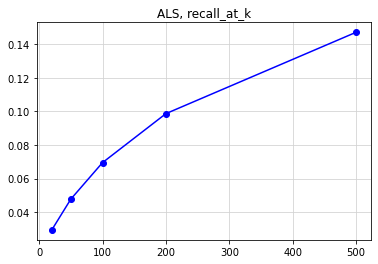

In [65]:
plt.plot(k_list, recall_als_list, 'bo-')

plt.grid(color="lightgrey")
plt.title('ALS, recall_at_k')
plt.show()

#### Own recommendations

In [66]:
k_list = [20, 50, 100, 200, 500]

recall_own_rec_list = []

for k in k_list:
    result_own_rec = CalcRecall(result_eval_matcher, USER_COL, recommender.get_own_recommendations)
    recall_own_rec_list.append(result_own_rec)

In [67]:
recall_own_rec_list

[0.03928427679372909,
 0.06525657038145175,
 0.09604492955885034,
 0.13537278412833242,
 0.18205324555508678]

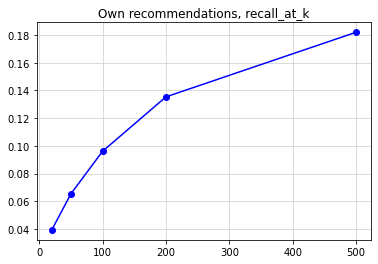

In [68]:
plt.plot(k_list, recall_own_rec_list, 'bo-')

plt.grid(color="lightgrey")
plt.title('Own recommendations, recall_at_k')
plt.show()

#### Similar items recommendation

In [69]:
k_list = [20, 50, 100, 200, 500]

recall_similar_items_list = []

for k in k_list:
    result_similar_items = CalcRecall(result_eval_matcher, USER_COL, recommender.get_similar_items_recommendation)
    recall_similar_items_list.append(result_similar_items)

In [70]:
recall_similar_items_list

[0.017455795280180805,
 0.03353296712886949,
 0.0539508490608188,
 0.08601050099275484,
 0.13561152773564533]

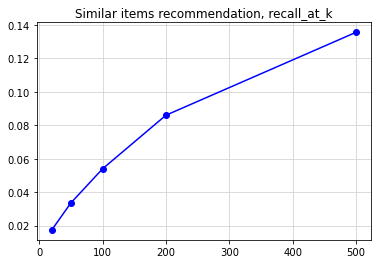

In [71]:
plt.plot(k_list, recall_similar_items_list, 'bo-')

plt.grid(color="lightgrey")
plt.title('Similar items recommendation, recall_at_k')
plt.show()

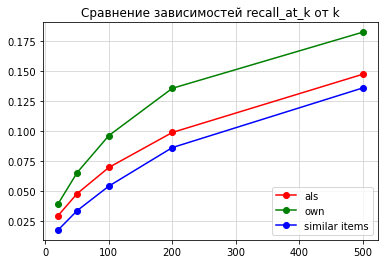

In [72]:
plt.plot(k_list, recall_als_list, 'ro-', label='als')
plt.plot(k_list, recall_own_rec_list, 'go-', label='own')
plt.plot(k_list, recall_similar_items_list, 'bo-', label='similar items')

plt.legend(loc="lower right")
plt.grid(color="lightgrey")
plt.title('Сравнение зависимостей recall_at_k от k')
plt.show()

#### Выводы

###### Дают ли own recommendtions + top-popular лучший recall? - 
Да, данный метод показал абсолюный максимум при К=500 (0.18205324555508678)

###### B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}
С увеличением К улучшается recall@k, при этом скорость увеличения recall@k замедляется с увеличением К, происходит своего рода насыщение

###### C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?
Наиболее разумным, на мой взгляд, является К в диапазоне от 100 до 300. До 100 значение recall@k возрастает значительно, а после 300 несущественно.

### Задание 2.

Обучите модель 2-ого уровня, при этом:

- Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар

- Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_ranker

- Вырос ли precision@5 при использовании двухуровневой модели?

In [73]:
TOPK_PRECISION = 5
sorted(calc_precision(result_eval_matcher, TOPK_PRECISION), key=lambda x: x[1],reverse=True)

[('own_rec', 0.17712691771268974),
 ('als_rec', 0.11483031148303009),
 ('sim_item_rec', 0.06015806601580705),
 ('result', 0.06015806601580705)]

In [74]:
def new_user_features(data, user_features):
    new_user_features = user_features.merge(data, on='user_id', how='left')
    #Чек
    basket = new_user_features.groupby(['user_id'])['sales_value'].sum().reset_index()
    baskets_qnt = new_user_features.groupby('user_id')['basket_id'].count().reset_index()
    baskets_qnt.rename(columns={'basket_id': 'baskets_qnt'}, inplace=True)
    #Средний недельный чек
    average_basket = basket.merge(baskets_qnt)
    average_basket['average_basket'] = average_basket.sales_value / average_basket.baskets_qnt
    average_basket['sum_per_week'] = average_basket.sales_value / new_user_features.week_no.nunique()
    average_basket = average_basket.drop(['sales_value', 'baskets_qnt'], axis=1)
    user_features = user_features.merge(average_basket)

    return user_features


def new_item_features(data, item_features):
    new_item_features = item_features.merge(data, on='item_id', how='left')
    
    # Цена
    price = new_item_features.groupby('item_id')['sales_value'].sum() \
                            / new_item_features.groupby('item_id')['quantity'].sum()
    price = price.groupby('item_id').mean().reset_index()
    price.columns = ['item_id', 'price']
    price['price'].fillna(0, inplace= True)
    
    #Количество продаж и среднее количество продаж товара

    item_qnt = new_item_features.groupby(['item_id'])['quantity'].count().reset_index()
    item_qnt.rename(columns={'quantity': 'quantity_of_sales'}, inplace=True)
    item_qnt['quantity_of_sales_per_week'] = \
                item_qnt['quantity_of_sales'] / new_item_features['week_no'].nunique()
    item_features = item_features.merge(item_qnt, on='item_id')
    
    return item_features

def train_test_preprocessing(data):    
    users_lvl_2 = pd.DataFrame(data['user_id'].unique())
    users_lvl_2.columns = ['user_id']

    train_users = data_train_matcher['user_id'].unique()
    train_users.shape

    users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]
    users_lvl_2_ = users_lvl_2.copy()
    users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=50))
    
    s = users_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
    s.name = 'item_id'

    users_lvl_2 = users_lvl_2.drop('candidates', axis=1).join(s)
    
    users_lvl_2['flag'] = 1

    targets_lvl_2 = data[['user_id', 'item_id']].copy()
    targets_lvl_2.head(2)

    targets_lvl_2['target'] = 1  

    targets_lvl_2 = users_lvl_2.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')

    targets_lvl_2['target'].fillna(0, inplace= True)
    targets_lvl_2.drop('flag', axis=1, inplace=True)

    targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
    targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')

    X = targets_lvl_2.drop('target', axis=1)
    y = targets_lvl_2[['target']]
    
    return X, y


def get_final_recomendation(X_test, test_preds_proba, data_val_ranker):
    X_test['predict_proba'] = test_preds_proba

    X_test.sort_values(['user_id', 'predict_proba'], ascending=False, inplace=True)

    result = X_test.groupby('user_id').head(5)

    recs = result.groupby('user_id')['item_id']
    recomendations = []
    for user, preds in recs:
        recomendations.append({'user_id': user, 'recomendations': preds.tolist()})

    recomendations = pd.DataFrame(recomendations)

    result_lvl_2 = data_val_ranker.groupby('user_id')['item_id'].unique().reset_index()
    result_lvl_2.columns=['user_id', 'actual']

    result_lvl_2 = result_lvl_2.merge(recomendations)
    
    return result_lvl_2

In [76]:
item_features = new_item_features(data_train_ranker, item_features)
item_features

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,quantity_of_sales,quantity_of_sales_per_week
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB,0,0.0
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,,0,0.0
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,,0,0.0
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ,0,0.0
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ,0,0.0
...,...,...,...,...,...,...,...,...,...
92348,18293142,6384,DRUG GM,National,BOOKSTORE,PAPERBACK BOOKS,,0,0.0
92349,18293439,6393,DRUG GM,National,BOOKSTORE,CHILDRENS LOW END,,0,0.0
92350,18293696,6406,DRUG GM,National,BOOKSTORE,PAPERBACK BEST SELLER,,0,0.0
92351,18294080,6442,DRUG GM,National,BOOKSTORE,PAPERBACK BOOKS,,0,0.0


In [77]:
user_features = new_user_features(data_train_ranker, user_features)
user_features

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id,average_basket,sum_per_week
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1,2.569774,56.963333
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7,2.085000,31.275000
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8,2.472683,50.690000
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13,6.248079,184.318333
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16,3.435714,4.008333
...,...,...,...,...,...,...,...,...,...,...
796,35-44,U,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,2494,3.096596,24.256667
797,45-54,A,75-99K,Homeowner,Unknown,3,1,2496,2.442676,57.810000
798,45-54,U,35-49K,Unknown,Single Male,1,None/Unknown,2497,3.504063,93.441667
799,25-34,U,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,2498,3.124407,30.723333


In [78]:
X_train, y_train = train_test_preprocessing(data_train_ranker)

In [79]:
cat_feats = X_train.columns[2:].tolist()

In [80]:
X_train[cat_feats] = X_train[cat_feats].astype('category')
X_test, y_test = train_test_preprocessing(data_val_ranker)
X_test[cat_feats] = X_test[cat_feats].astype('category')

In [81]:
lgb = LGBMClassifier(objective='binary', 
                     #max_depth=7, 
                     categorical_column=cat_feats)
lgb.fit(X_train, y_train)

test_preds_proba = lgb.predict_proba(X_test)[:, 1]

C:\Users\AVB\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\AVB\anaconda3\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


In [82]:
test_preds_proba

array([0.28031329, 0.28031329, 0.03251762, ..., 0.02229369, 0.00815938,
       0.04263357])

In [84]:
result_lvl_2 = get_final_recomendation(X_test, test_preds_proba, data_val_ranker)

In [93]:
lvl_2_prec = result_lvl_2.apply(lambda row: precision_at_k(row['recomendations'], row['actual']), axis=1).mean()
print(f"Precision@k: {lvl_2_prec}")

Precision@k: 0.1519607843137238


###### Вырос ли precision@5 при использовании двухуровневой модели?
Precision@5 при использовании двухуровневой модели (0.1519607843137238) выше чем у всех одноуровневых моделей за исключением own recommendtions + top-popular (0.17712691771268974).